# Подготовка датасета для экпериментального метода аугментации данных при помощи модели Stable Diffusion

Для увеличения объема примеров обнаружения объектов в датасете, предлагаем метод который при помощи модели Stable Diffusion может в значительное количество раз увеличить объем, предлагая различного рода объекты. 

Для более лучшей генерации необходимо сделать файнтюнинг модели, для этого создадим собственный датасет для файнтюнинга. Возьмем пример датасета `lambdalabs/pokemon-blip-captions`, и наш датасет `object detection` в формате `COCO` и проведем `promt engeniring` чо бы сформировать датасет для файнтюнинга `Stable Diffusion`

In [1]:
from datasets import load_dataset
# from pycocotools.coco import COCO
# import matplotlib.pyplot as plt
# from PIL import Image
# import numpy as np
# from tqdm.notebook import tqdm

In [2]:
ds = load_dataset("lambdalabs/pokemon-blip-captions", split="train")
sample = ds[0]

Using custom data configuration lambdalabs--pokemon-blip-captions-baa94796864cc987
Found cached dataset parquet (/root/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-baa94796864cc987/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


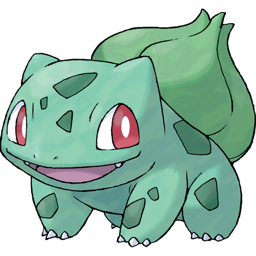

In [3]:
sample['image'].resize((256, 256))

In [4]:
sample["text"]

'a drawing of a green pokemon with red eyes'

Формат к которому необходимо привести датасет

```
{
'image':Pillow.Image,
'text':promt_text
}
```

Взглянем на наш датасет с `object detection`  в  формат COCO. И пройдемся по алгоритму создания элемента датасета для обучения StableDiffusion 

In [5]:
import random

from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from tools import image_grid

Загружаем COCO датасет

In [6]:
ann_file = '../dataset/test/result.json'
dataset_path = '../dataset/test/img'

In [7]:
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Смотрим какие категории у нас есть

In [8]:
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print(f'COCO Категории: {nms}')

COCO Категории: ['crack', 'fistula', 'rupture']


Выберем первый класс и посмотрим на изображение с разметкой

In [9]:
catIds = coco.getCatIds(catNms=[nms[0]])

imgIds = coco.getImgIds(catIds=catIds)
print(f'Id изображений с выбранной категорией: {imgIds}')

Id изображений с выбранной категорией: [2, 3, 4, 5, 6, 7, 8, 9]


Такое изображение нашлось, отобразим его и посмотрим на разметку

In [10]:
imgId = imgIds[6]

In [11]:
img = coco.loadImgs(imgId)[0]
img

{'width': 960,
 'height': 1280,
 'id': 8,
 'file_name': '/app/dataset/test/img/239_7_8984.jpg'}

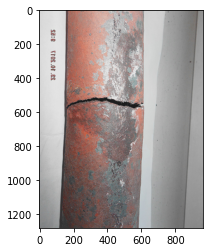

In [12]:
im = Image.open(img['file_name'])
plt.imshow(im)

anns=[{'id': 11, 'image_id': 8, 'category_id': 0, 'segmentation': [], 'bbox': [162, 494, 463, 115], 'ignore': 0, 'iscrowd': 0, 'area': 53245}]


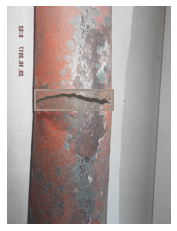

In [13]:
plt.imshow(im); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
print(f'anns={anns}')
coco.showAnns(anns, draw_bbox=True)

Посмотрим на ббоксы

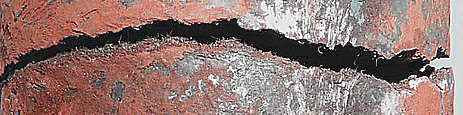

In [14]:
deffects = []
for ann in anns:
    x, y, w, h = [int(x) for x in ann['bbox']]
    im = Image.open(coco.loadImgs(ids=[imgId])[0]['file_name'])
    im_np = np.array(im)[y:y+h, x:x+w]
    deffects.append(Image.fromarray(im_np))
    
image_grid(deffects, 1, len(deffects))

Поскольку StableDiffusion обучается на 512х512, приведем ббоксы к формату 1:1

In [15]:
orig_w, orig_h = im.size
print(f'Исходный размер изображения: {(orig_w, orig_h)}')
# padding_w, padding_h = int(orig_w * SCALE_PADDING_PERCENT), int(orig_h * SCALE_PADDING_PERCENT)
# print(f'Отступы по ширине/высоте {(padding_w, padding_h)}')

Исходный размер изображения: (960, 1280)


In [16]:
x, y, w, h = anns[0]['bbox']
print(f'Исходный ббокс: {(x, y, w, h)}')
center_point = (x + w // 2, y + h // 2)
print(f'Центр ббокса {center_point}')

max_side = max(w,h)
print(f'Максимальная сторона {max_side}')

delta_w, delta_h = max_side - w, max_side - h
print(f'отступ по ширине|длине = {delta_w}|{delta_h}')


new_x =  x - delta_w // 2
new_y = y - delta_h // 2

if new_x < 0:
    max_side += new_x
    new_x = 0
    
if new_y < 0:
    max_side += new_y
    new_y = 0

residual_w, residual_h = (0,0)
if new_x + max_side > orig_w:
    residual_w = new_x + max_side - orig_w
if new_y + max_side > orig_h:
    residual_h = new_y + max_side - orig_h

residual = max(residual_w, residual_h)
max_side -= residual

square_bbox = [
    new_x,
    new_y,
    max_side,
    max_side
]
print(f'квадратный ббокс = {square_bbox}')


Исходный ббокс: (162, 494, 463, 115)
Центр ббокса (393, 551)
Максимальная сторона 463
отступ по ширине|длине = 0|348
квадратный ббокс = [162, 320, 463, 463]


In [17]:
# square_bbox = [-183, 235, 877, 877]

In [18]:
# anns=[{'id': 0, 'image_id': 0, 'category_id': 0, 'segmentation': [], 'bbox': square_bbox, 'ignore': 0, 'iscrowd': 0, 'area': square_bbox[2]*square_bbox[3]}]
anns

[{'id': 11,
  'image_id': 8,
  'category_id': 0,
  'segmentation': [],
  'bbox': [162, 494, 463, 115],
  'ignore': 0,
  'iscrowd': 0,
  'area': 53245}]

In [19]:
anns[0]['bbox'] = square_bbox
anns[0]['area'] = square_bbox[2]*square_bbox[3]
anns

[{'id': 11,
  'image_id': 8,
  'category_id': 0,
  'segmentation': [],
  'bbox': [162, 320, 463, 463],
  'ignore': 0,
  'iscrowd': 0,
  'area': 214369}]

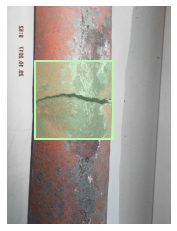

In [20]:
plt.imshow(im); plt.axis('off')
coco.showAnns(anns, draw_bbox=True)

Поскольку StableDiffusion зависит от контекста, то увеличим область ббокса (если это возможно)

In [21]:
SCALE_PADDING_PERCENT = 0.2
square_bbox_with_padding = None
if (square_bbox[2] == orig_w or square_bbox[3] == orig_h):
    square_bbox_with_padding = square_bbox
else:
    padding = int(max_side * SCALE_PADDING_PERCENT)
    print(f'padding={padding}')
    square_bbox_with_padding = [
        square_bbox[0] - padding,
        square_bbox[1] - padding,
        square_bbox[2] + padding * 2,
        square_bbox[3] + padding * 2
    ]
    
    #Проверяем увеличенный ббокс на выход за границы изображения
    x1, y1 = (square_bbox_with_padding[0], square_bbox_with_padding[1])
    x2, y2 = (x1 + square_bbox_with_padding[2], y1 + square_bbox_with_padding[3])
    
    # если ббокс и так большой, то нет смысла его увеличивать и оставляем как есть
    if x2 - x1 > orig_w or y2 - y1 > orig_h:
        square_bbox_with_padding = square_bbox.copy()
    else:
        new_offset_x = 0
        new_offset_y = 0

        if x2 > orig_w:
            print('x2 > orig_w')
            new_offset_x = orig_w - x2
        if y2 > orig_h:
            print('y2 > orig_h')
            new_offset_y = orig_h - y2
        if x1 < 0:
            print('x1 < 0')
            new_offset_x = -x1
        if y1 < 0:
            print('y1 < 0')
            new_offset_y = -y1


        x1 += new_offset_x
        y1 += new_offset_y

        print(x1, y1)
        print(new_offset_x, new_offset_y)

        square_bbox_with_padding[0] = x1
        square_bbox_with_padding[1] = y1

print(f'square_bbox_with_padding={square_bbox_with_padding}')

padding=92
70 228
0 0
square_bbox_with_padding=[70, 228, 647, 647]


In [22]:
anns[0]['bbox'] = square_bbox_with_padding
anns[0]['area'] = square_bbox_with_padding[2]*square_bbox_with_padding[3]
anns

[{'id': 11,
  'image_id': 8,
  'category_id': 0,
  'segmentation': [],
  'bbox': [70, 228, 647, 647],
  'ignore': 0,
  'iscrowd': 0,
  'area': 418609}]

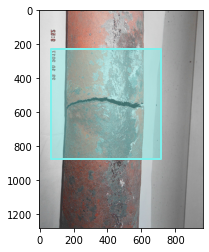

In [23]:
plt.imshow(im); plt.axis('on')
coco.showAnns(anns, draw_bbox=True)

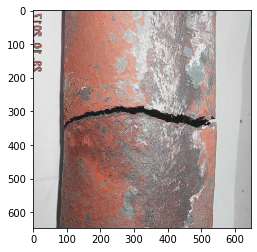

In [24]:
im_np = np.array(im)[ anns[0]['bbox'][1] : anns[0]['bbox'][1] + anns[0]['bbox'][3], anns[0]['bbox'][0] : anns[0]['bbox'][0] + anns[0]['bbox'][2] ]
curr_img = Image.fromarray(im_np)
plt.imshow(curr_img)

Далее нужно сгенерировать промпт для получившегося изображения

In [25]:
labelid2text = {0:'crack', 1:'fistula', 2:'rupture'} # Конвертация id класса в название

PROMT_TEMAPLTE = [
    'photo of a <OBJ> on a metal pipe',
    '<OBJ> on a metal pipe',
    '<OBJ> on a old metal pipe',
    'corrosion <OBJ> on a metal pipe',
    'corrosion <OBJ> on a old metal pipe',
    '<OBJ> on a rusty metal pipe'
]

def generate_promt(obj:str):
    return random.choice(PROMT_TEMAPLTE).replace('<OBJ>', obj)
    # return [x.replace('<OBJ>', obj) for x in PROMT_TEMAPLTE]

In [26]:
test_dataset = []

generated_promt = generate_promt(labelid2text[anns[0]['category_id']])

test_dataset.append({
    'text': generated_promt,
    'image': curr_img
})

In [27]:
test_dataset

[{'text': 'corrosion crack on a metal pipe',
  'image': <PIL.Image.Image image mode=RGB size=647x647 at 0x7EFD0A4D1810>}]

# Создание DS

In [28]:
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [29]:
# ann_file = '../dataset/pipe/new_pipe/project-14-at-2022-08-09-10-03-1117d404/result.json'
# dataset_path = '../dataset/pipe/new_pipe/project-14-at-2022-08-09-10-03-1117d404/images'
ann_file = '../dataset/pipe/old_pipe/project-15-at-2022-08-09-10-07-0f0f5133/result.json'
dataset_path = '../dataset/pipe/old_pipe/project-15-at-2022-08-09-10-07-0f0f5133/images'

In [30]:
coco = COCO(ann_file)

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: '../dataset/pipe/old_pipe/project-15-at-2022-08-09-10-07-0f0f5133/result.json'

In [ ]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO Категории: \n{}'.format(' '.join(nms)))

In [ ]:
# catIds = coco.getCatIds(catNms=['Трещина', 'Разрыв', 'Свищ', 'Крип', 'Выход трубы из ряда']) # Получаем те id которые содержат выбранные нами категории
catIds = coco.getCatIds(catNms=['Трещина', 'Разрыв', 'Свищ'])
print(f'catIds: {catIds}')
imgIds = coco.getImgIds(catIds=catIds ) # получаем изображения где есть наши категории
print(f'imgIds: {imgIds}')

In [ ]:
imgs = coco.imgs

In [ ]:
imgs = list(imgs.values())

In [ ]:
len(imgs)

In [ ]:
labelid2text = {0:'exit from row', 1:'creep', 2:'gap', 3:'fistula', 4:'crack'} # Конвертация id класса в название

In [ ]:
PROMT_TEMAPLTE = [
    'Photo of a <OBJ> on a metal pipe',
    '<OBJ> on a metal pipe'
]

In [ ]:
def generate_promt(obj:str):
    return [x.replace('<OBJ>', obj) for x in PROMT_TEMAPLTE]

In [ ]:
SCALE_PADDING_PERCENT = 0.5

In [ ]:
new_dataset = []
for img in tqdm(imgs):
    ann_id = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    ann_img = coco.loadAnns(ann_id)
    img_path = img["file_name"].replace("\\", "/") # делаем замену windows на linux пути
    print(img_path)
    img_org = Image.open(f"{dataset_path}/{img_path}")
    org_w, org_h = img_org.size
    padding_w, padding_h = int(org_w*SCALE_PADDING_PERCENT), int(org_h*SCALE_PADDING_PERCENT)
    
    for ann in ann_img:
        x, y, w,h = [int(x) for x in ann['bbox']]
        center_point = (x + w // 2, y + h // 2)
        max_side = max(w,h)

        delta_w, delta_h = max_side - w, max_side - h
        delta = delta_w  if delta_h == 0 else delta_h

        square_bbox = [
            x - delta_w // 2,
            y - delta_h // 2,
            max_side,
            max_side
        ]

        padding = int(max_side * SCALE_PADDING_PERCENT)
        square_bbox_with_padding = [
            square_bbox[from datasets import Dataset
dataset = Dataset.from_list(new_dataset) # Загрузим датасет из списка в объект 

dataset.save_to_disk('../dataset/promt_datasets/3') # Сохраним на диск датасе0] - padding,
            square_bbox[1] - padding,
            square_bbox[2] + padding * 2,
            square_bbox[3] + padding * 2
        ]
        
        x1, y1 = (square_bbox_with_padding[0], square_bbox_with_padding[1])
        x2, y2 = (x1 + square_bbox_with_padding[2], y1 + square_bbox_with_padding[3])

        new_offset_x = 0
        new_offset_y = 0
        if x2 > org_w:
            new_offset_x = org_w - x2
        if y2 > org_h:
            new_offset_y = org_h - y2
        if x1 < 0:
            new_offset_x = -x1
        if y1 < 0:
            new_offset_y = -y1


        x1 += new_offset_x
        y1 += new_offset_y

        square_bbox_with_padding[0] = x1
        square_bbox_with_padding[1] = y1
        
        crop_x1, crop_y1 = square_bbox_with_padding[0], square_bbox_with_padding[1]
        crop_x2, crop_y2 = crop_x1 + square_bbox_with_padding[2], crop_y1 + square_bbox_with_padding[3]
        
        
        im_np = np.array(img_org)[ crop_y1:crop_y2, crop_x1:crop_x2]
        cr_img = Image.fromarray(im_np)
        generated_promt = generate_promt(labelid2text[ann['category_id']])
        for promt in generated_promt:
            new_dataset.append({
                'text': promt,
                'image': cr_img
            })

In [ ]:
new_images = [new_dataset[i]['image'] for i in range(len(new_dataset))]
len(new_images)

In [ ]:
from datasets import Dataset
dataset = Dataset.from_list(new_dataset) # Загрузим датасет из списка в объект 

dataset.save_to_disk('../dataset/promt_datasets/3') # Сохраним датасет на диск 

In [ ]:
new_dataset = Dataset.load_from_disk('../dataset/promt_datasets/2')
len(new_dataset)

In [ ]:
new_dataset[7]['image']

In [ ]:
for i in range(len(new_dataset)):
    if i % 2 != 0:
        new_dataset[i]["image"].save(f"../dataset/pipe/for_stable_diffusion/croped/2/{i}_{new_dataset[i]['text'].split()[0]}.jpg")

# После удаления нерелевантных изображений формируем новый датасет

In [ ]:
from glob import glob
from PIL import Image
import os
from tqdm import tqdm

In [ ]:
total_dataset = []
for path in tqdm(glob('../dataset/pipe/for_stable_diffusion/croped/2/*')):
    i = int(os.path.basename(path).split('.')[0].split('_')[0])
    total_dataset.append(new_dataset[i - 1])
    total_dataset.append(new_dataset[i])

In [ ]:
total_dataset[6]['image']

In [ ]:
total_dataset[6]['text']

In [ ]:
from datasets import Dataset
dataset = Dataset.from_list(total_dataset) # Загрузим датасет из списка в объект

dataset.save_to_disk('../dataset/promt_datasets/total/2') # Сохраним на диск датасе

In [ ]:
from datasets import load_dataset
test_dataset = load_dataset("beans", split="train")


In [ ]:
test_dataset

In [ ]:
dataset